In [24]:
 import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")

import numpy as np
from collections import OrderedDict
from ccode.plotting import plot_gates
from ccode.gates import rectangular_gate, half_disk_gate
from ccode.finite_system import finite_system
from scipy import constants
import matplotlib.pyplot as plt

import poisson
import kwant
from potential import linear_problem_instance
from Hamiltonian import discrete_system_coordinates

from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    TwoDEGLayer,
)

from itertools import product
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union

# Y-shaped geometry

#### Parameters

In [55]:
thickness_barrier = 4
thickness_twoDEG = 4
thickness_gates = 6

grid_spacing_twoDEG = 1
grid_spacing_normal = 1
grid_spacing_dielectric = 5
grid_spacing_air = 5
grid_spacing_gate = grid_spacing_twoDEG

permittivity_metal = 5000
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

#### Make gate polygons using Shapely

In [70]:
# one only needs to define the arm length L, and the channel width
L = 70
width = 13
gap = 4

R = L/np.sqrt(2)

In [71]:
# Boundaries within Poisson region
zmin = -0.5
zmax = 0.5
xmax = R
xmin = -xmax
ymin = 0
ymax = R + L - width
boundaries = [xmin, xmax, ymin, ymax, zmin, zmax]
total_width = 2*xmax
total_length = ymax

In [58]:
Y = unary_union(
    (
        Polygon(half_disk_gate(R=R, npts=3)).difference(Polygon(half_disk_gate(R=R-width*np.sqrt(2), npts=3))),
        Polygon(rectangular_gate(center=(0,R+L/2-width), width=width, length=L))
    )
)

gates = Polygon(rectangular_gate(center=(0, (R+L-width)/2), length=R+L-width-1,width=2*R)).difference(Y)

aux_rectangle_1 = rectangular_gate(length=R+2*gap, width=R+gap, center=(R/2, R/2-width/2))
aux_rectangle_2 = rectangular_gate(length=R+2*gap, width=R+gap, center=(-R/2, R/2-width/2))

def gate_coords(obj, difference = None, common = None, gap = None):
    
    if type(common) == np.ndarray:
        return np.array(list(obj.intersection(Polygon(common)).exterior.coords))
        
    else:
        if gap != None:
            return np.array(list(obj.difference(Polygon(difference).buffer(gap)).exterior.coords))
        else:
            return np.array(list(obj.difference(Polygon(difference)).exterior.coords))


gates_vertex = [gate_coords(gates[0], common = aux_rectangle_2), 
                gate_coords(gates[2], difference = aux_rectangle_1), 
                gate_coords(gates[2], difference = aux_rectangle_2), 
                gate_coords(gates[1], common = aux_rectangle_1), 
                gate_coords(gates[0], difference = aux_rectangle_2, gap = gap), 
                gate_coords(gates[1], difference = aux_rectangle_1, gap = gap)]

gates_name = ['left_1', 'left_2', 'right_1', 'right_2', 'top_1', 'top_2']

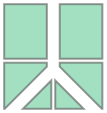

In [6]:
unary_union([Polygon(gate) for gate in gates_vertex])

#### Construct layout object for the Poisson solver

In [7]:
# Solve for Poisson system

layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

layout.add_layer(
    TwoDEGLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    ),
    center=True,
)

height = thickness_twoDEG / 2

layout.add_layer(
    SimpleChargeLayer(
        "Al2O3",
        thickness_barrier,
        permittivity_Al2O3,
        grid_spacing_dielectric,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    )
)

height += thickness_barrier


layout.add_layer(OverlappingGateLayer(thickness_gates,
                                      permittivity_metal,
                                      grid_spacing_gate,
                                      layer_name = gates_name,
                                      gate_objects = gates_vertex,
                                      remove_points = False,
                                      add_to_previous_layer = False,
                                      z_bottom = height,
                                      fix_overlap = True
                                     )
            )

#### Build Poisson object

In [8]:
%%time

poisson_system = layout.build()

checking intersection
finished checking intersection
Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 1min 42s, sys: 5.67 s, total: 1min 48s
Wall time: 1min 48s


In [9]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

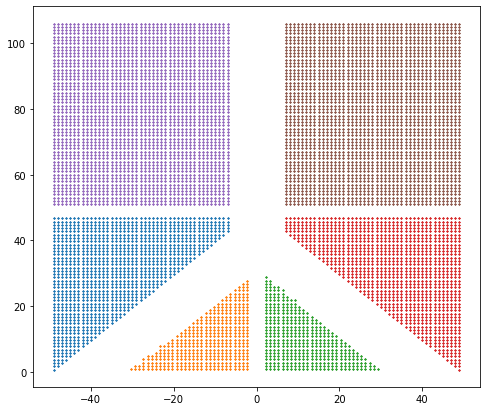

In [10]:
plt.figure(figsize = (8, 7))
for name, indices in voltage_regions.items():
    grid_to_plot = grid_points[indices][:, [0, 1]]
    plt.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)

#### LU decomposition of finite system

In [11]:
%%time

linear_problem = linear_problem_instance(poisson_system)

CPU times: user 11.8 s, sys: 1.06 s, total: 12.9 s
Wall time: 12.8 s


In [12]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('mixed', 'twoDEG')], boundaries=boundaries
)

#### Build kwant object

In [17]:
# import importlib
import ccode.finite_system
importlib.reload(ccode.finite_system)

<module 'ccode.finite_system' from '/home/tinkerer/trijunction-design/analysis/ccode/finite_system.py'>

In [81]:
boundaries = np.array(boundaries) * a
boundaries

array([-4.94974747e-07,  4.94974747e-07,  0.00000000e+00,  1.06497475e-06,
       -5.00000000e-09,  5.00000000e-09])

In [82]:
R *= a
R

4.949747468305833e-07

In [83]:
width *= a

In [84]:
#crds = site_coords[:, [0, 1]]
#grid_spacing = grid_spacing_twoDEG
#offset = crds[0]%grid_spacing

# Build kwant system

a = 10e-9
l = 120 * a
w = 7 * a

geometry ={'nw_l': l, 'nw_w': w,
           's_w': boundaries[1] - boundaries[0],
           's_l': boundaries[3] - boundaries[2],
           'centers':[[-R+width/np.sqrt(2), 0],
                      [-(-R+width/np.sqrt(2)), 0], 
                      [0,boundaries[3]+l-a]
                     ]
          }

In [85]:
%%time

trijunction, f_params = ccode.finite_system.finite_system(**geometry)
trijunction = trijunction.finalized()

CPU times: user 569 ms, sys: 14.1 ms, total: 583 ms
Wall time: 581 ms


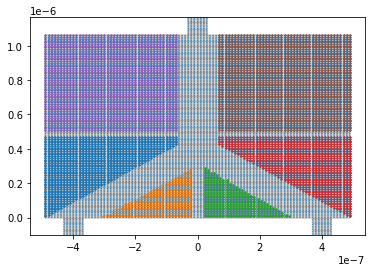

In [98]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax)
ax.set_ylim(-10*a, boundaries[3]+10*a)


for name, indices in voltage_regions.items():
    grid_to_plot = a*grid_points[indices][:, [0, 1]]
    ax.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)

#### Define potential